# Res Net in CIFAR-100
---
ResNet-18

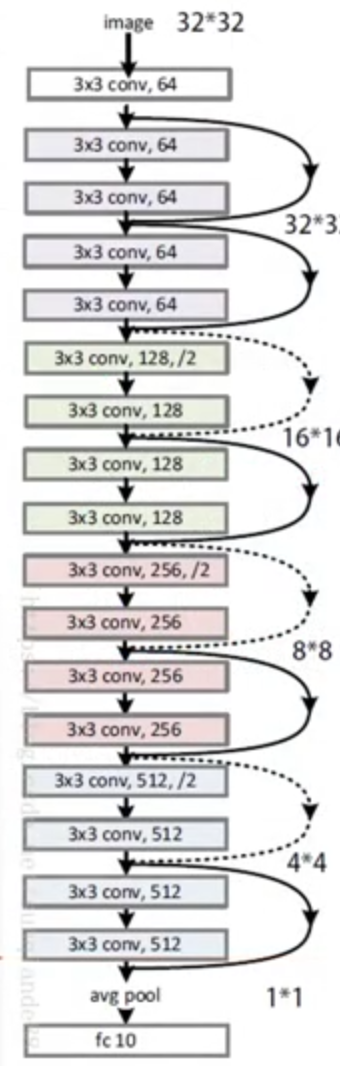

### Knowledge
1. 自定义残差单元
2. 更简洁的训练
3. 了解BN层

In [ ]:
# 导入模块
import tensorflow as tf
from tensorflow.keras import layers,models,datasets,optimizers,Sequential,losses
import datetime

In [ ]:
# 超参数
batch_size = 600

In [ ]:
# 导入数据
cifar100 = datasets.cifar100.load_data()

In [ ]:
# 数据预处理
def pre_process(x,y):
    x = tf.cast(x,dtype=tf.float32)/255.
    y = tf.cast(y,dtype=tf.int32)
    y = tf.squeeze(y,axis=0)
    return x,y
def get_data(data,func,batch_size):
    '''
    返回可迭代的train_data和test_data
    '''
    (x,y),(x_test,y_test) = data
    db = tf.data.Dataset.from_tensor_slices((x,y))
    train_data = db.map(func).shuffle(10000).batch(batch_size)
    db_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
    test_data = db_test.map(func).shuffle(10000).batch(batch_size) # test数据可以不用打乱
    return train_data,test_data
    
train_data,test_data = get_data(cifar100,pre_process,batch_size)

In [ ]:
# 建立ResUnit

class ResUnit(layers.Layer):
    def __init__(self,channel_num,stride = 1):
        '''
        
        '''
        super(ResUnit,self).__init__()
        self.stride = stride
        self.conv1 = layers.Conv2D(channel_num,(3,3),strides = stride,padding = 'same')
        self.bn1 = layers.BatchNormalization()
        self.ac = layers.Activation(tf.nn.relu)
        self.conv2 = layers.Conv2D(channel_num,(3,3),strides = 1,padding = 'same')
        self.bn2 = layers.BatchNormalization()
        
        if stride != 1:  # 若尺度缩减，则进行下采样
            self.downsample = layers.Conv2D(channel_num,[1,1],strides = stride)
        else:
            self.downsample = lambda x:x


    def call(self,inputs,training = None):
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.ac(out)
        out = self.conv2(out)
        out1 = self.bn2(out)
        
        out2 = self.downsample(inputs)
        
        output = layers.add([out1,out2])
        
        output = tf.nn.relu(output)
        return output

In [ ]:
class ResNet(models.Model):
    def __init__(self,shapes,channels,strides):
        # conv
        super(ResNet,self).__init__()
        self.conv = Sequential([
            layers.Conv2D(64,3,padding='same'),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu)
        ])
        # res
        self.unit_list = [self.ResModule(l,c,s) for l,c,s in zip(shapes,channels,strides)]
        # GlobalAvgPool
        # fc
        self.fc = Sequential([
            layers.GlobalAvgPool2D(),
            layers.Dense(100,activation=tf.nn.softmax)
        ])
        
    
    def call(self,inputs,training = None):
        out = self.conv(inputs)
        for unit in self.unit_list:
            out = unit(out)
        out = self.fc(out)
        return out
    
    def ResModule(self,layer,channel,strides):
        model = Sequential()
        model.add(ResUnit(channel,strides))
        for _ in range(layer-1):
            model.add(ResUnit(channel)) 
        return model
    
    def ResNet_18():
        return ResNet([2,2,2,2],[64,128,256,512],[1,2,2,2])

In [ ]:
rn = ResNet.ResNet_18()
rn.build(input_shape = (None,32,32,3))

In [ ]:
rn.summary()

In [ ]:
max_iter = 5
optimizer = optimizers.Adam(learning_rate=0.0001)
for iter_step in range(max_iter):
    for i,(ix,iy) in enumerate(train_data):
        begin_time = datetime.datetime.now()
        with tf.GradientTape() as tape:
            out_fc = rn(ix)
            iy_onehot = tf.one_hot(iy,depth=100)
            ce = losses.categorical_crossentropy(iy_onehot,out_fc)
            loss = tf.reduce_mean(ce)
        grads = tape.gradient(loss,rn.trainable_variables)
        optimizer.apply_gradients(zip(grads,rn.trainable_variables))
        end_time = datetime.datetime.now()
        if i%50==0:
            print('step {0} : loss = {1} {2} pic/s '.format(i,float(loss),batch_size/(end_time-begin_time).total_seconds()))
    # vaildation
    tot = 0
    for x_t,y_t in test_data:
        prob = rn(x_t)
        predict = tf.cast(tf.argmax(prob,axis = 1),dtype=tf.int32) 
        corr = tf.equal(y_t,predict)
        corr = tf.reduce_sum(tf.cast(corr,dtype = tf.int32))
        tot += corr
    print('Iter{0} -- Accuracy = {1}'.format(iter_step,int(tot)/10000.))

In [ ]:
# import time
# import datetime
# a = datetime.datetime.now()
# time.sleep(1)
# b = datetime.datetime.now()
# print(dir(b-a))
# print(1/(b-a).total_seconds())